In [16]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [17]:
dataset = 'keypoint.csv'
model_save_path = 'keypoint_classifier.hdf5'
tflite_save_path = 'keypoint_classifier.tflite'
labels = 'keypoint_classifier_label.csv'

# Set number of classes

In [18]:
with open(labels, 'r') as fp:
    NUM_CLASSES = len(fp.readlines())

# Dataset reading

In [19]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [20]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [23]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 42)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                860       
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 7)                 77        
                                                                 
Total params: 1,147
Trainable params: 1,147
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [25]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [26]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/10 [==>...........................] - ETA: 3s - loss: 2.0097 - accuracy: 0.1719
Epoch 1: saving model to keypoint_classifier.hdf5
10/10 [==============================] - 1s 35ms/step - loss: 2.0107 - accuracy: 0.1856 - val_loss: 1.9318 - val_accuracy: 0.2129
Epoch 2/1000
 1/10 [==>...........................] - ETA: 0s - loss: 2.0020 - accuracy: 0.2031
Epoch 2: saving model to keypoint_classifier.hdf5
10/10 [==============================] - 0s 9ms/step - loss: 1.9294 - accuracy: 0.2162 - val_loss: 1.8442 - val_accuracy: 0.3391
Epoch 3/1000
 1/10 [==>...........................] - ETA: 0s - loss: 1.9230 - accuracy: 0.2109
Epoch 3: saving model to keypoint_classifier.hdf5
10/10 [==============================] - 0s 8ms/step - loss: 1.8706 - accuracy: 0.2632 - val_loss: 1.7751 - val_accuracy: 0.3713
Epoch 4/1000
 1/10 [==>...........................] - ETA: 0s - loss: 1.7683 - accuracy: 0.3906
Epoch 4: saving model to keypoint_classifier.hdf5
10/10 [=====================

In [27]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

4/4 [==============================] - 0s 1ms/step - loss: 0.0936 - accuracy: 0.9901


In [28]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [29]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 80ms/step
[9.7001350e-01 1.0530566e-03 7.4489038e-03 1.3770541e-02 5.6744278e-03
 1.6990708e-03 3.4053889e-04]
0


# Confusion matrix

13/13 [==============================] - 0s 836us/step


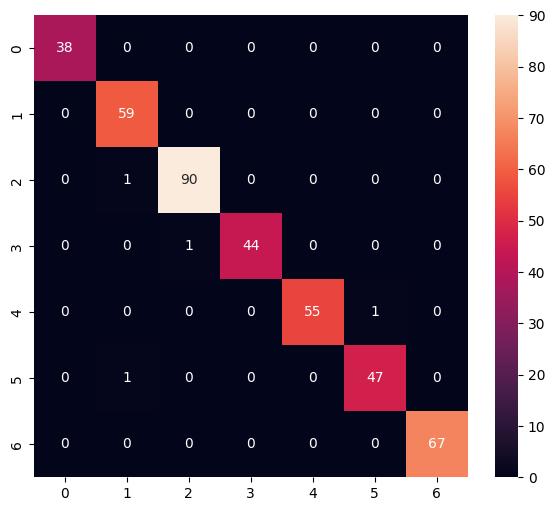

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       0.97      1.00      0.98        59
           2       0.99      0.99      0.99        91
           3       1.00      0.98      0.99        45
           4       1.00      0.98      0.99        56
           5       0.98      0.98      0.98        48
           6       1.00      1.00      1.00        67

    accuracy                           0.99       404
   macro avg       0.99      0.99      0.99       404
weighted avg       0.99      0.99      0.99       404



In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [31]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [32]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/2h/lgrzygf9513_s5fjb23885lm0000gn/T/tmpl3zf8jel/assets


2022-11-11 10:47:21.127979: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-11 10:47:21.127996: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-11 10:47:21.128753: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/2h/lgrzygf9513_s5fjb23885lm0000gn/T/tmpl3zf8jel
2022-11-11 10:47:21.130564: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-11 10:47:21.130589: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/2h/lgrzygf9513_s5fjb23885lm0000gn/T/tmpl3zf8jel
2022-11-11 10:47:21.135253: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-11-11 10:47:21.136648: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-11 10:47:21.184382: I tensorflow/cc/saved_model/loader.

6704

# Inference test

In [33]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [34]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [35]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [36]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 202 µs, sys: 72 µs, total: 274 µs
Wall time: 269 µs


In [37]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.7001350e-01 1.0530570e-03 7.4489038e-03 1.3770541e-02 5.6744278e-03
 1.6990708e-03 3.4053889e-04]
0
